# Import Libraries

In [1]:
# data handling
import pandas as pd
import numpy as np
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

# load numpy array from csv file
from numpy import loadtxt

#for splitting our data
from sklearn.model_selection import train_test_split

#plotting performance
import matplotlib.pyplot as plt

In [ ]:
#!pip install --upgrade tensorflow_hub

In [2]:
#used for transfer learning
import tensorflow_hub as hub

In [ ]:
#!pip install tensorflow_decision_forests

In [ ]:
#import tensorflow_decision_forests as tfdf #Windows, this library is still not available

In [5]:
#access google drive
#from google.colab import drive, files
#get data from google drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#check that we are using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Preparation
Custom functions to help with handling the data

## Text Encoder

In [4]:
def encode_text(text, encode_type, seq_len=3):
  """
  Input txt and outputs tokenised text.
  encode_type: bow = encode documents into vector where the coefficient for 
  each token is based on counting words
  """
  if(encode_type == 'bow'):
    encoder = Tokenizer()# create the tokenizer
    encoder.fit_on_texts(text)
    bow = encoder.texts_to_matrix(text, mode='count')
    # summarize what was learned
    print("Encoder Summary:\n")
    print(encoder.word_counts)
    print(encoder.document_count)
    print(encoder.word_index)
    print(encoder.word_docs)
    print(type(bow))
    print(bow.shape) #8.26gb / 23677 = 0.00035 GB/column if saved to file and 200205 * 0.00035 = 70GB if saved to file!
    return bow
  elif(encode_type == 'sequence'):
    encoder = Tokenizer()# create the tokenizer
    encoder.fit_on_texts(text)
    t2s = encoder.texts_to_sequences(text)
    pt2s = pad_sequences(t2s, padding='post', truncating='post', maxlen=seq_len)
    print(pt2s)
    print(type(pt2s))
    print(pt2s.shape)
    return pt2s

  elif(encode_type == 'one-hot'):
    labels = pd.get_dummies(text).values
    print(labels.shape)
    return labels

def train_val_test(X_features, y_target, tc=237, pt_embed=False):
    """
    Splits dataset into 10% for testting, 10% for validation and 
    the remaining 80% for training data. By first spliting data for 
    training and test data (90:10), then training with validation.

    returns X_train, X_test, X_val, max_words, seq_len
    """
    # Reduce word amount to speed up training
    truncate = tc #592 #1183 #2368 #6000 # 23677 
    mxw = 23681 #our vocab value we found during data cleaning
    sl = truncate

    X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(X_features, y_target, test_size=0.1, random_state=42)

    X_train_set, X_val_set, y_train_set, y_val_set = train_test_split(X_train_set, y_train_set, test_size=0.1111, random_state=42)

    print("** Before Truncate **")
    print("Training data shape:", X_train_set.shape)
    print("Training labels shape:", y_train_set.shape)
    print("\n")
    print("Validation data shape:", X_val_set.shape)
    print("Validation labels shape:", y_val_set.shape)
    print("\n")
    print("Test data shape:", X_test_set.shape)
    print("Test labels shape:", y_test_set.shape)

    if(pt_embed):
      return X_train_set, X_test_set, X_val_set, y_train_set, y_val_set, y_test_set, mxw, sl
    else:
      X_train_set = X_train_set[:, :truncate]
      X_test_set = X_test_set[:, :truncate]
      X_val_set = X_val_set[:, :truncate]

      print("\n")
      print("** After Truncate: " + str(truncate) + " **")
      print("Training data shape:", X_train_set.shape)
      print("Training labels shape:", y_train_set.shape)
      print("\n")
      print("Validation data shape:", X_val_set.shape)
      print("Validation labels shape:", y_val_set.shape)
      print("\n")
      print("Test data shape:", X_test_set.shape)
      print("Test labels shape:", y_test_set.shape)

      return X_train_set, X_test_set, X_val_set, y_train_set, y_val_set, y_test_set, mxw, sl

## Model Builder

In [5]:
def build_simple_rnn(id=1000, od=50, il=128, m_type='bow'):
    """
    returns a simple rnn model
    needs input_dim, output_dim and input_length passed.
    """
    if(m_type=='bow'):
      model = tf.keras.Sequential()
      #batch size (numer of observations), #number of columns (timesteps), just have 1 indicator but can increase with more
      model.add(layers.Embedding(input_dim=id, 
                                output_dim=od,
                                input_length=il))
      model.add(layers.GlobalAveragePooling1D())
      model.add(layers.Reshape((1, od)))
      model.add(layers.SimpleRNN(8))#embedding dimension #seq_len
      model.add(layers.Dropout(0.2))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model
    elif(m_type=='word_vector'):
      model = tf.keras.Sequential()
      #batch size (numer of observations), #number of columns (timesteps), just have 1 indicator but can increase with more
      model.add(layers.Embedding(input_dim=id, 
                                output_dim=od,
                                input_length=il))
      model.add(layers.Conv1D(25,3,padding='valid',activation='relu',strides=1))
      model.add(layers.SimpleRNN(8))#embedding dimension #seq_len
      model.add(layers.Dropout(0.2))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model
    elif(m_type=='pre_trained'):
      model = tf.keras.Sequential()
      # Add the pretrained word embeddings layer
      hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                                dtype=tf.string, trainable=True)
      model.add(hub_layer)
      model.add(layers.Reshape((1, od)))
      model.add(layers.SimpleRNN(8))#embedding dimension #seq_len
      #regularisation layer which randomly turns off 
      #activations of some neurons in the model to prevent overfitting
      model.add(layers.Dropout(0.5))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model

def build_lstm(id=1000, od=50, il=128, m_type='single'):
    if(m_type=='single'):
      model = tf.keras.Sequential()
      # Add the pretrained word embeddings layer
      hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                                dtype=tf.string, trainable=True)
      model.add(hub_layer)
      #we need to reshape our data for LSTM. 
      # It expects (batch_size, num_timesteps or sequence_length, num_features)
      model.add(layers.Reshape((128, 1))) 
      model.add(layers.LSTM(8))
      model.add(layers.Dropout(0.5))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
      model.summary()
      return model
    elif(m_type=='multi'):
      model = tf.keras.Sequential()
      # Add the pretrained word embeddings layer
      hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                                dtype=tf.string, trainable=True)
      model.add(hub_layer)
      #we need to reshape our data for LSTM. 
      # It expects (batch_size, num_timesteps or sequence_length, num_features)
      model.add(layers.Reshape((128, 1))) 
      model.add(layers.LSTM(8, return_sequences=True))
      model.add(layers.LSTM(8))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model

def build_cnn(m_type='mhks'):
    if(m_type=='mhks_cnn'):
      model = tf.keras.Sequential()
      model.add(layers.Conv1D(128, 5, activation='relu'))
      model.add(layers.Conv1D(64, 5, activation='relu'))
      model.add(layers.GlobalMaxPooling1D())
      model.add(layers.Dense(10, activation='relu'))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      model.summary()
      return model
    elif(m_type=='mhks_cnn_lstm'):
      model = tf.keras.Sequential()
      model.add(layers.Embedding(input_dim=max_words, 
                                output_dim=82,
                                input_length=seq_len))
      model.add(layers.Reshape((1, od)))
      model.add(layers.LSTM(82, return_sequences=True))
      #model.add(layers.Reshape((64, 0))) #we need to reshape our data for LSTM. It expects (batch_size, num_timesteps or sequence_length, num_features)
      model.add(layers.Conv1D(128, 5, activation='relu'))
      model.add(layers.Conv1D(64, 5, activation='relu'))
      model.add(layers.GlobalMaxPooling1D())
      model.add(layers.Dense(10, activation='relu'))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model

def build_random_forest():
      model = tfdf.keras.RandomForestModel(verbose=2)
      return model



## Import BBC Dataset

In [6]:
#df = pd.read_csv('/content/drive/MyDrive/data/bbc-text.csv')
df = pd.read_csv('./data/bbc-text.csv')

In [7]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


## Encode X and y

In [8]:
X = df.text.values

In [9]:
y = df.category.values

In [10]:
y = encode_text(y, encode_type='one-hot')

(2225, 5)


#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [11]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237, pt_embed=True)

** Before Truncate **
Training data shape: (1779,)
Training labels shape: (1779, 5)


Validation data shape: (223,)
Validation labels shape: (223, 5)


Test data shape: (223,)
Test labels shape: (223, 5)


# Simple RNN: Pretrained Word Embeddings

#### Build Simple RNN Model using webTitle pretrained embeddings

In [15]:
BBC_RNN_model = build_simple_rnn(max_words, 128, seq_len, m_type='pre_trained')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 1096      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 5)                 45        
                                                                 
Total params: 124,643,829
Trainable params: 124,643,829
Non-trainable params: 0
_________________________________________________________________


#### Train Simple RNN Model using webTitle PTE

In [16]:
BBC_RNN_history = BBC_RNN_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10) #batch_size=32

Epoch 1/10
56/56 [==============================] - 199s 4s/step - loss: 1.2630 - accuracy: 0.5447 - val_loss: 0.8476 - val_accuracy: 0.8969
Epoch 2/10
56/56 [==============================] - 210s 4s/step - loss: 0.7596 - accuracy: 0.7915 - val_loss: 0.5626 - val_accuracy: 0.9596
Epoch 3/10
56/56 [==============================] - 215s 4s/step - loss: 0.5749 - accuracy: 0.8561 - val_loss: 0.4065 - val_accuracy: 0.9686
Epoch 4/10
56/56 [==============================] - 211s 4s/step - loss: 0.4607 - accuracy: 0.8904 - val_loss: 0.3163 - val_accuracy: 0.9686
Epoch 5/10
56/56 [==============================] - 221s 4s/step - loss: 0.4083 - accuracy: 0.8977 - val_loss: 0.2600 - val_accuracy: 0.9731
Epoch 6/10
56/56 [==============================] - 243s 4s/step - loss: 0.3541 - accuracy: 0.8999 - val_loss: 0.2213 - val_accuracy: 0.9686
Epoch 7/10
56/56 [==============================] - 224s 4s/step - loss: 0.3008 - accuracy: 0.9264 - val_loss: 0.1891 - val_accuracy: 0.9731
Epoch 8/10
56

#### Evaluation of Simple RNN Model using webTitle T2S

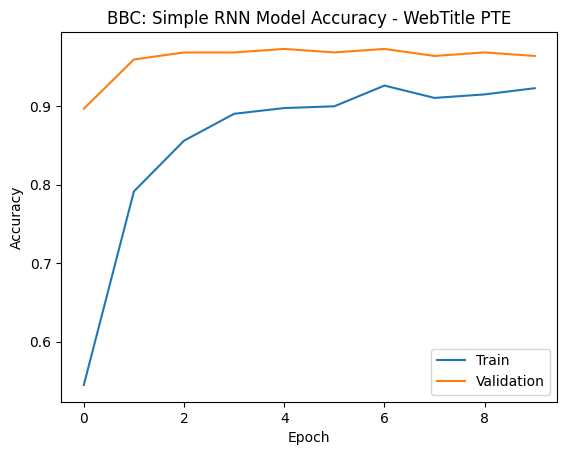

In [17]:
# Plot training & validation accuracy values
plt.plot(BBC_RNN_history.history['accuracy'])
plt.plot(BBC_RNN_history.history['val_accuracy'])
plt.title('BBC: Simple RNN Model Accuracy - WebTitle PTE')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

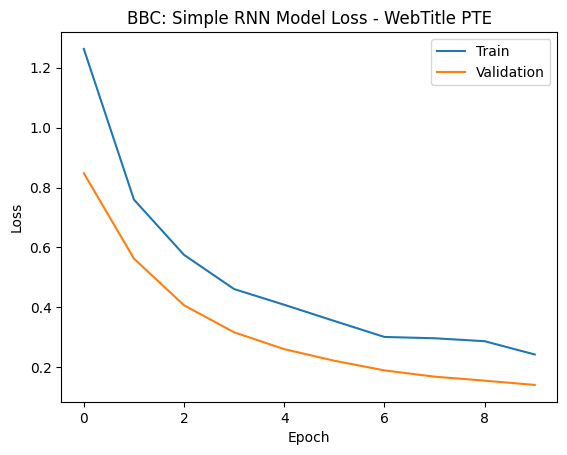

In [18]:
# Plot training & validation loss values
plt.plot(BBC_RNN_history.history['loss'])
plt.plot(BBC_RNN_history.history['val_loss'])
plt.title('BBC: Simple RNN Model Loss - WebTitle PTE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [19]:
print("BBC: RNN - WebTitle - PTE")
loss_and_metrics = BBC_RNN_model.evaluate(X_test, y_test, verbose=2)
print("BBC: RNN Test Loss", round(loss_and_metrics[0], 3))
print("BBC: RNN Test Accuracy", round(loss_and_metrics[1], 3))

BBC: RNN - WebTitle - PTE
7/7 - 3s - loss: 0.1722 - accuracy: 0.9507 - 3s/epoch - 464ms/step
BBC: RNN Test Loss 0.172
BBC: RNN Test Accuracy 0.951


#### Save Simple RNN Model using webTitle Bag of words 

In [20]:
#BBC_RNN_model.save('/content/bbc_rnn_model-wt-pte') #google colab
BBC_RNN_model.save('./models/bbc_rnn_model-wt-pte')

In [21]:
#!zip -r bbc_rnn_model-wt-pte.zip bbc_rnn_model-wt-pte

  adding: bbc_rnn_model-wt-pte/ (stored 0%)
  adding: bbc_rnn_model-wt-pte/keras_metadata.pb (deflated 86%)
  adding: bbc_rnn_model-wt-pte/assets/ (stored 0%)
  adding: bbc_rnn_model-wt-pte/assets/tokens.txt (deflated 43%)
  adding: bbc_rnn_model-wt-pte/fingerprint.pb (stored 0%)
  adding: bbc_rnn_model-wt-pte/variables/ (stored 0%)
  adding: bbc_rnn_model-wt-pte/variables/variables.index (deflated 59%)
  adding: bbc_rnn_model-wt-pte/variables/variables.data-00000-of-00001 (deflated 68%)
  adding: bbc_rnn_model-wt-pte/saved_model.pb (deflated 89%)


In [22]:
#files.download("/content/bbc_rnn_model-wt-pte.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Transfered RNN: Pretrained Word Embeddings

In [12]:
#build a similar model to the transferred model
BBC_Transfered_RNN_model = build_simple_rnn(max_words, 128, seq_len, m_type='pre_trained')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 1096      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 5)                 45        
                                                                 
Total params: 124,643,829
Trainable params: 124,643,829
Non-trainable params: 0
_________________________________________________________________


In [38]:
#!unzip rnn_model-wt-pte.zip -d rnn_model-wt-pte #only if rnn_model-wt-pte.zip was uploaded to google colab

Archive:  rnn_model-wt-pte.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of rnn_model-wt-pte.zip or
        rnn_model-wt-pte.zip.zip, and cannot find rnn_model-wt-pte.zip.ZIP, period.


In [13]:
# reconstruct guardian rnn model
#Guardian_RNN_model = keras.models.load_model("/content/drive/MyDrive/models/rnn_model-wt-pte")
Guardian_RNN_model = keras.models.load_model("./models/part-1/rnn_model-wt-pte")

In [14]:
# Extract a portion of the model excluding the final output
pretrained = keras.Model(
    Guardian_RNN_model.inputs, Guardian_RNN_model.layers[-1].input, name="pretrained_model"
)

pretrained.save_weights("pretrained_ckpt")
pretrained.summary()

Model: "pretrained_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_input (InputLay  [(None,)]                0         
 er)                                                             
                                                                 
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 1096      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
Total params: 124,643,784
Trainable params: 124,643,784
Non-trainable params: 0
____________________________________

In [15]:
# Now we load the weights from pretrained_ckpt into model.
BBC_Transfered_RNN_model.load_weights("pretrained_ckpt")

In [16]:
# Check that all of the pretrained weights have been loaded.
for a, b in zip(pretrained.weights, BBC_Transfered_RNN_model.weights):
    np.testing.assert_allclose(a.numpy(), b.numpy())

print("\n", "-" * 50)
BBC_Transfered_RNN_model.summary()


 --------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 1096      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 5)                 45        
                                                                 
Total params: 124,643,829
Trainable params: 124,643,829
Non-trainable params: 0
_______________________________________________________

In [17]:
print("BBC Transfered: RNN - WebTitle - PTE")
loss_and_metrics = BBC_Transfered_RNN_model.evaluate(X_test, y_test, verbose=2)
print("BBC Transfered: RNN Test Loss", round(loss_and_metrics[0], 3))
print("BBC Transfered: RNN Test Accuracy", round(loss_and_metrics[1], 3))

BBC Transfered: RNN - WebTitle - PTE
7/7 - 1s - loss: 2.1286 - accuracy: 0.1390 - 973ms/epoch - 139ms/step
BBC Transfered: RNN Test Loss 2.129
BBC Transfered: RNN Test Accuracy 0.139


In [18]:
#BBC_RNN_model.save('/content/bbc_rnn_model-wt-pte') #google colab
BBC_Transfered_RNN_model.save('./models/part-2/bbc_rnn_model-wt-transfer')

INFO:tensorflow:Assets written to: ./models/part-2/bbc_rnn_model-wt-transfer\assets


INFO:tensorflow:Assets written to: ./models/part-2/bbc_rnn_model-wt-transfer\assets


In [ ]:
#!zip -r bbc_rnn_model-wt-transfer.zip bbc_rnn_model-wt-transfer

  adding: bbc_rnn_model-wt-pte/ (stored 0%)
  adding: bbc_rnn_model-wt-pte/keras_metadata.pb (deflated 86%)
  adding: bbc_rnn_model-wt-pte/assets/ (stored 0%)
  adding: bbc_rnn_model-wt-pte/assets/tokens.txt (deflated 43%)
  adding: bbc_rnn_model-wt-pte/fingerprint.pb (stored 0%)
  adding: bbc_rnn_model-wt-pte/variables/ (stored 0%)
  adding: bbc_rnn_model-wt-pte/variables/variables.index (deflated 59%)
  adding: bbc_rnn_model-wt-pte/variables/variables.data-00000-of-00001 (deflated 68%)
  adding: bbc_rnn_model-wt-pte/saved_model.pb (deflated 89%)


In [ ]:
#files.download("/content/bbc_rnn_model-wt-transfer.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# RNN: On-the-fly Word Embeddings

#### Encode Bag-of-Words Representation

In [9]:
X = encode_text(X, encode_type='bow')

Encoder Summary:

OrderedDict([('tv', 525), ('future', 373), ('in', 17725), ('the', 52636), ('hands', 91), ('of', 20008), ('viewers', 87), ('with', 5354), ('home', 663), ('theatre', 94), ('systems', 134), ('plasma', 14), ('high', 559), ('definition', 99), ('tvs', 19), ('and', 18611), ('digital', 415), ('video', 363), ('recorders', 20), ('moving', 79), ('into', 1132), ('living', 81), ('room', 66), ('way', 740), ('people', 2045), ('watch', 111), ('will', 4473), ('be', 5805), ('radically', 10), ('different', 258), ('five', 536), ('years', 1003), ('time', 1322), ('that', 8257), ('is', 8555), ('according', 422), ('to', 25113), ('an', 2813), ('expert', 29), ('panel', 80), ('which', 2585), ('gathered', 38), ('at', 4638), ('annual', 169), ('consumer', 218), ('electronics', 83), ('show', 603), ('las', 31), ('vegas', 30), ('discuss', 59), ('how', 645), ('these', 514), ('new', 1978), ('technologies', 116), ('impact', 132), ('one', 1892), ('our', 682), ('favourite', 110), ('pastimes', 1), ('us', 1

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [10]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237)

** Before Truncate **
Training data shape: (1779, 29727)
Training labels shape: (1779, 5)


Validation data shape: (223, 29727)
Validation labels shape: (223, 5)


Test data shape: (223, 29727)
Test labels shape: (223, 5)


** After Truncate: 237 **
Training data shape: (1779, 237)
Training labels shape: (1779, 5)


Validation data shape: (223, 237)
Validation labels shape: (223, 5)


Test data shape: (223, 237)
Test labels shape: (223, 5)


#### Build Simple RNN Model using webTitle on-the-fly embeddings

In [11]:
#build a similar model to the transferred model
BBC_OTF_RNN_model = build_simple_rnn(max_words, 50, seq_len, m_type='bow')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 237, 50)           1184050   
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 50)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 472       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 5)                 45        
                                                        

#### Train Simple RNN Model using webTitle on-the-fly embeddings

In [12]:
BBC_OTF_RNN_history = BBC_OTF_RNN_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10) #batch_size=32

Epoch 1/10
56/56 [==============================] - 5s 31ms/step - loss: 1.6068 - accuracy: 0.2147 - val_loss: 1.6011 - val_accuracy: 0.1928
Epoch 2/10
56/56 [==============================] - 1s 25ms/step - loss: 1.5961 - accuracy: 0.2316 - val_loss: 1.5956 - val_accuracy: 0.1928
Epoch 3/10
56/56 [==============================] - 2s 28ms/step - loss: 1.5893 - accuracy: 0.2406 - val_loss: 1.5875 - val_accuracy: 0.2063
Epoch 4/10
56/56 [==============================] - 2s 27ms/step - loss: 1.5805 - accuracy: 0.2468 - val_loss: 1.5723 - val_accuracy: 0.2466
Epoch 5/10
56/56 [==============================] - 1s 25ms/step - loss: 1.5674 - accuracy: 0.2788 - val_loss: 1.5528 - val_accuracy: 0.2735
Epoch 6/10
56/56 [==============================] - 1s 26ms/step - loss: 1.5488 - accuracy: 0.2777 - val_loss: 1.5332 - val_accuracy: 0.2601
Epoch 7/10
56/56 [==============================] - 1s 25ms/step - loss: 1.5325 - accuracy: 0.2827 - val_loss: 1.5152 - val_accuracy: 0.3094
Epoch 8/10
56

#### Evaluation of Simple RNN Model using OTF

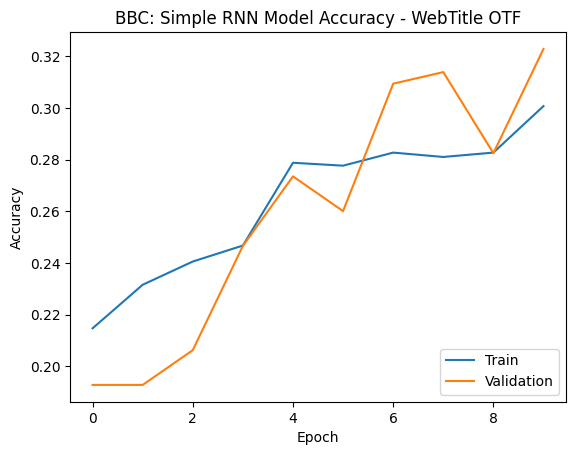

In [18]:
# Plot training & validation accuracy values
plt.plot(BBC_OTF_RNN_history.history['accuracy'])
plt.plot(BBC_OTF_RNN_history.history['val_accuracy'])
plt.title('BBC: Simple RNN Model Accuracy - WebTitle OTF')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

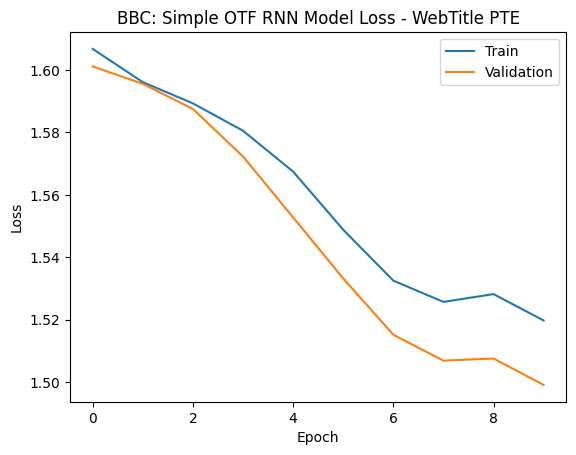

In [14]:
# Plot training & validation loss values
plt.plot(BBC_OTF_RNN_history.history['loss'])
plt.plot(BBC_OTF_RNN_history.history['val_loss'])
plt.title('BBC: Simple RNN Model Loss - WebTitle OTF')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [16]:
print("BBC: RNN - WebTitle - OTF")
loss_and_metrics = BBC_OTF_RNN_model.evaluate(X_test, y_test, verbose=2)
print("BBC: RNN OTF Test Loss", round(loss_and_metrics[0], 3))
print("BBC: RNN OTF Test Accuracy", round(loss_and_metrics[1], 3))

BBC: RNN - WebTitle - OTF
7/7 - 0s - loss: 1.4736 - accuracy: 0.2780 - 57ms/epoch - 8ms/step
BBC: RNN OTF Test Loss 1.474
BBC: RNN OTF Test Accuracy 0.278


#### Save Simple RNN Model using webTitle Bag of words 

In [17]:
#BBC_RNN_model.save('/content/bbc_rnn_model-wt-pte') #google colab
BBC_OTF_RNN_model.save('./models/part-2/bbc_rnn_model-wt-otf')

INFO:tensorflow:Assets written to: ./models/bbc_rnn_model-wt-otf\assets


In [ ]:
#!zip -r bbc_rnn_model-wt-otf.zip bbc_rnn_model-wt-otf

  adding: bbc_rnn_model-wt-pte/ (stored 0%)
  adding: bbc_rnn_model-wt-pte/keras_metadata.pb (deflated 86%)
  adding: bbc_rnn_model-wt-pte/assets/ (stored 0%)
  adding: bbc_rnn_model-wt-pte/assets/tokens.txt (deflated 43%)
  adding: bbc_rnn_model-wt-pte/fingerprint.pb (stored 0%)
  adding: bbc_rnn_model-wt-pte/variables/ (stored 0%)
  adding: bbc_rnn_model-wt-pte/variables/variables.index (deflated 59%)
  adding: bbc_rnn_model-wt-pte/variables/variables.data-00000-of-00001 (deflated 68%)
  adding: bbc_rnn_model-wt-pte/saved_model.pb (deflated 89%)


In [ ]:
#files.download("/content/bbc_rnn_model-wt-otf.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Transfered RNN: On-the-fly Word Embeddings

In [19]:
#build a similar model to the transferred model
BBC_OTF_Transfered_RNN_model = build_simple_rnn(max_words, 50, seq_len, m_type='bow')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 237, 50)           1184050   
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 reshape_1 (Reshape)         (None, 1, 50)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 472       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                      

In [ ]:
#!unzip rnn_model-wt-bow.zip -d rnn_model-wt-bow #only if rnn_model-wt-bow.zip was uploaded to google colab

Archive:  rnn_model-wt-pte.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of rnn_model-wt-pte.zip or
        rnn_model-wt-pte.zip.zip, and cannot find rnn_model-wt-pte.zip.ZIP, period.


In [21]:
# reconstruct guardian rnn model
#Guardian_RNN_model = keras.models.load_model("/content/drive/MyDrive/models/rnn_model-wt-pte")
#to stop TypeError: weight_decay is not a valid argument, kwargs should be empty for `optimizer_experimental.Optimizer`, add compile false and compile after
Guardian_OTF_RNN_model = keras.models.load_model("./models/part-1/rnn_model-wt-bow", compile=False)
Guardian_OTF_RNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [23]:
# Extract a portion of the model excluding the final output
pretrained_otf = keras.Model(
    Guardian_OTF_RNN_model.inputs, Guardian_OTF_RNN_model.layers[-1].input, name="pretrained_otf"
)

pretrained_otf.save_weights("pretrained_otf_ckpt")
pretrained_otf.summary()

Model: "pretrained_otf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4_input (InputLay  [(None, 237)]            0         
 er)                                                             
                                                                 
 embedding_4 (Embedding)     (None, 237, 50)           1184050   
                                                                 
 global_average_pooling1d_3   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 reshape_1 (Reshape)         (None, 1, 50)             0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 8)                 472       
                                                                 
 dropout_1 (Dropout)         (None, 8)              

In [24]:
# Now we load the weights from pretrained_ckpt into model.
BBC_OTF_Transfered_RNN_model.load_weights("pretrained_otf_ckpt")

In [25]:
# Check that all of the pretrained weights have been loaded.
for a, b in zip(pretrained_otf.weights, BBC_OTF_Transfered_RNN_model.weights):
    np.testing.assert_allclose(a.numpy(), b.numpy())

print("\n", "-" * 50)
BBC_OTF_Transfered_RNN_model.summary()


 --------------------------------------------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 237, 50)           1184050   
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 reshape_1 (Reshape)         (None, 1, 50)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 472       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
 

In [27]:
print("BBC Transfered: RNN - WebTitle - OTF")
loss_and_metrics = BBC_OTF_Transfered_RNN_model.evaluate(X_test, y_test, verbose=2)
print("BBC Transfered: RNN Test Loss", round(loss_and_metrics[0], 3))
print("BBC Transfered: RNN Test Accuracy", round(loss_and_metrics[1], 3))

BBC Transfered: RNN - WebTitle - OTF
7/7 - 0s - loss: 1.7214 - accuracy: 0.1704 - 412ms/epoch - 59ms/step
BBC Transfered: RNN Test Loss 1.721
BBC Transfered: RNN Test Accuracy 0.17


In [28]:
#BBC_RNN_model.save('/content/bbc_rnn_model-wt-pte') #google colab
BBC_OTF_Transfered_RNN_model.save('./models/part-2/bbc_rnn_model-wt-otf-transfer')

INFO:tensorflow:Assets written to: ./models/part-2/bbc_rnn_model-wt-otf-transfer\assets


In [ ]:
#!zip -r bbc_rnn_model-wt-otf.zip bbc_rnn_model-wt-otf

  adding: bbc_rnn_model-wt-pte/ (stored 0%)
  adding: bbc_rnn_model-wt-pte/keras_metadata.pb (deflated 86%)
  adding: bbc_rnn_model-wt-pte/assets/ (stored 0%)
  adding: bbc_rnn_model-wt-pte/assets/tokens.txt (deflated 43%)
  adding: bbc_rnn_model-wt-pte/fingerprint.pb (stored 0%)
  adding: bbc_rnn_model-wt-pte/variables/ (stored 0%)
  adding: bbc_rnn_model-wt-pte/variables/variables.index (deflated 59%)
  adding: bbc_rnn_model-wt-pte/variables/variables.data-00000-of-00001 (deflated 68%)
  adding: bbc_rnn_model-wt-pte/saved_model.pb (deflated 89%)


In [ ]:
#files.download("/content/bbc_rnn_model-wt-otf-transfer.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>